<center><span>The aim of this notebook is to build a metrics dashboard</span></center>

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageDraw
import einops

import json
import glob
import os
from functools import reduce

from typing import TypeVar, Generic, Union, Optional, Callable 
from __future__ import annotations

import MSSIM

In [2]:
Shape = TypeVar("Shape")
DType = TypeVar("DType")

class Array(np.ndarray, Generic[Shape, DType]):
    pass

##### Data

In [3]:
json_data_path  = "labeled_samples_json"
image_data_path = "labeled_samples"

# List of sample filenames
fnames = [
    os.path.basename(i).split(".")[0]
    for i in glob.glob(f"{json_data_path}/*")
]

# Dict with (img, json) paths
samples = {
    i: (image_data_path+"\\"+fnames[i]+".jpg", json_data_path+"\\"+fnames[i]+".json")
    for i,_ in enumerate(fnames)
}

##### Tools

In [4]:
def build_mask(img: Array['H,W,3', float], points: list[list[float, float]]) -> Array["H,W", bool]:
    points = list(map(tuple, points))
    mask = Image.new("L", img.shape[:-1][::-1], 0) # first width, then height
    ImageDraw.Draw(mask).polygon(points, outline=1, fill=255)
    
    return np.array(mask) > 0

In [5]:
def highlight(img: Array['H,W,3', float], msk: Array['H,W', bool], vals: tuple|int):
    """ Highlights the masked part of the image
    """
    if isinstance(vals, int):
        vals = (vals, vals, vals)

    for ind,v in enumerate(vals):
        channel = torch.where(~msk, img[:, :, ind], img[:, :, ind] - v)
        channel[channel<0] = 0
        img[:, :, ind] = channel.to(int)

    return img

##### Masking photos

In [6]:
sample_pictures = []
sample_masks = []
for (image_path, json_path) in samples.values():
    with open(json_path, "r") as file:
        data = json.loads(file.read())
        
    points = data["shapes"][0]["points"]
    image = np.array(Image.open(image_path))
    mask = build_mask(image, points)
    
    sample_pictures.append(torch.from_numpy(image))
    sample_masks.append(torch.from_numpy(mask))

##### Metrics

In [7]:
def IoU(*masks: Array['H,W', bool]) -> float:
    e = 1e-6
    return (reduce(torch.logical_and, masks).sum() + e) / \
           (reduce(torch.logical_or, masks).sum() + e)

In [8]:
metrics = {"IoU": IoU, "MS-SSIM": MSSIM.MS_SSIM()}

##### Dashboard / <b>In Progress</b>

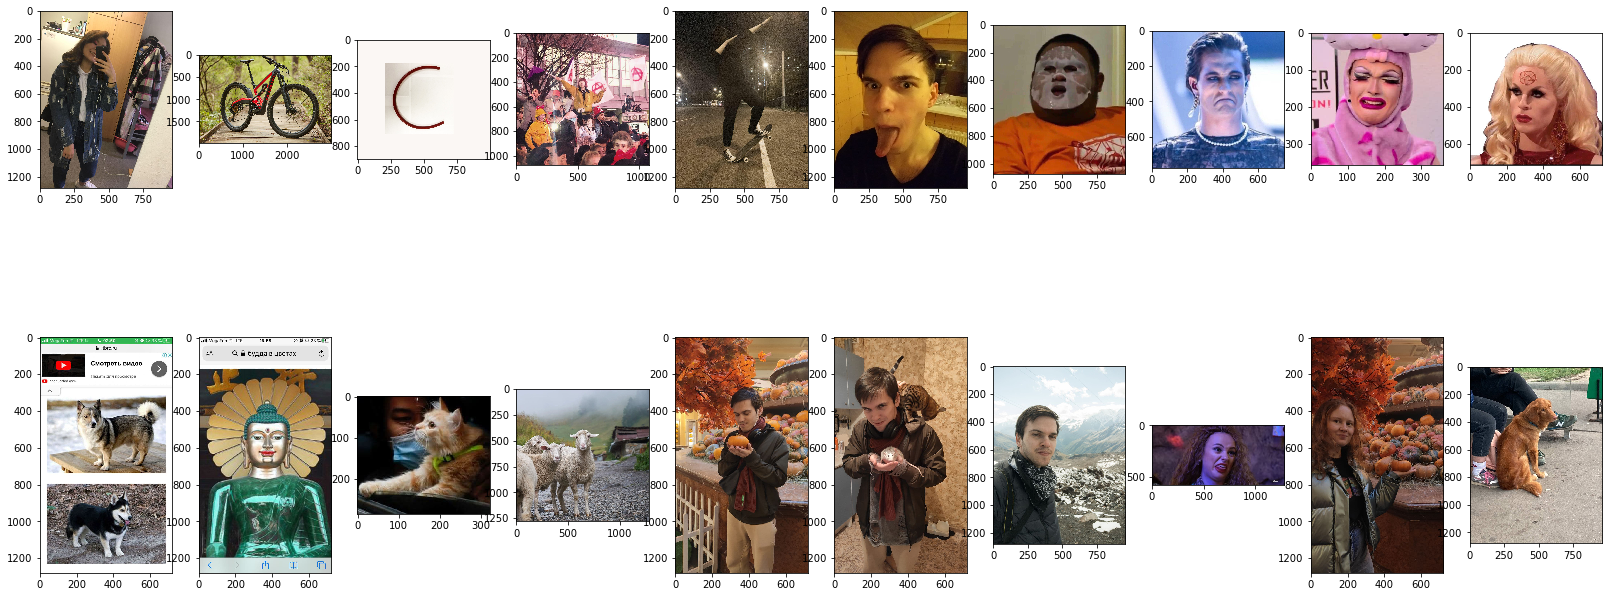

In [9]:
fig, axes = plt.subplots(nrows=2, ncols=10)
fig.set_size_inches(28, 12, forward=True)
axes = reduce((lambda a, b: [*a, *b]), axes)
for ax,p in zip(axes, sample_pictures):
    ax.imshow(p, interpolation='nearest')
plt.show()

In [10]:
def measure_success(metrics: dict[str, Callable], sample_masks: list[Array["H,W", bool]], modeled_masks: list[Array["H,W", bool]]) -> dict:
    mean_measure = {metric_name: 0 for metric_name in metrics.keys()}
    
    for metric_name, metric in metrics.items():
        for sm, mm in zip(sample_masks, modeled_masks):
            mean_measure[metric_name] += metric(sm, mm)
        mean_measure[metric_name] /= len(sample_masks)
        
    return mean_measure

##### Build a class

In [25]:
class Dashboard:
    def __init__(self,
                 metrics: dict[str, Callable],
                 images: list[Array["3,H,W", int]],
                 sample_masks: list[Array["H,W", bool]]
                ):
        self.device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        self.metrics = metrics
        self.images = images
        self.sample_masks = sample_masks
        
    def measure_success(self, modeled_masks: list[Array["H,W", bool]]) -> dict:
        """ In this method we run all over the metrics and
        calculate mean value for all pairs <sample mask - modeled mask>
        """
        mean_measure = {metric_name: 0 for metric_name in self.metrics.keys()}

        for metric_name, metric in self.metrics.items():
            for sm, mm in zip(self.sample_masks, modeled_masks):
                sm = sm.to(self.device)
                mm = mm.to(self.device)
                mean_measure[metric_name] += metric(sm, mm)
            mean_measure[metric_name] /= len(self.sample_masks)

        return mean_measure
    
    def show(self, modeled_masks: list[Array["H,W", bool]]):
        cols_num = 5
        rows_num = len(modeled_masks)*2 // cols_num + (len(modeled_masks)*2 % cols_num > 0)
        
        fig, axes = plt.subplots(nrows=rows_num, ncols=cols_num)
        even_axes = [axes[i] for i in range(len(axes)) if i%2==0]
        odd_axes = [axes[i] for i in range(len(axes)) if i%2!=0]
        even_axes = reduce((lambda a, b: [*a, *b]), even_axes)
        odd_axes = reduce((lambda a, b: [*a, *b]), odd_axes)
        
        fig.set_size_inches(28, 35, forward=True)
        
        for ax_even,m,i in zip(even_axes, modeled_masks, self.images.copy()):
            img = highlight(i, m, (0, 120, 10))
            ax_even.imshow(img, interpolation='nearest', aspect='auto')
                
        for ax_odd,m,i in zip(odd_axes, self.sample_masks, self.images.copy()):
            img = highlight(i, m, (0, 120, 10))
            ax_odd.imshow(img, interpolation='nearest', aspect='auto')
            
        plt.show()
        
    def __call__(self, modeled_masks: list[Array["H,W", bool]], show=True):
        metrics_results = self.measure_success(modeled_masks)
        for n,v in metrics_results.items():
            print(f"{n}\t\t{v}")
            
        if show is True:
            self.show(modeled_masks)

##### Using:

In [26]:
dashboard = Dashboard(metrics, sample_pictures, sample_masks)

In [27]:
modeled_masks = sample_masks.copy()
modeled_masks = [torch.rand(*i.shape)>0.5 for ind,i in enumerate(modeled_masks)]

IoU		0.25506705045700073
MS-SSIM		0.9954439997673035


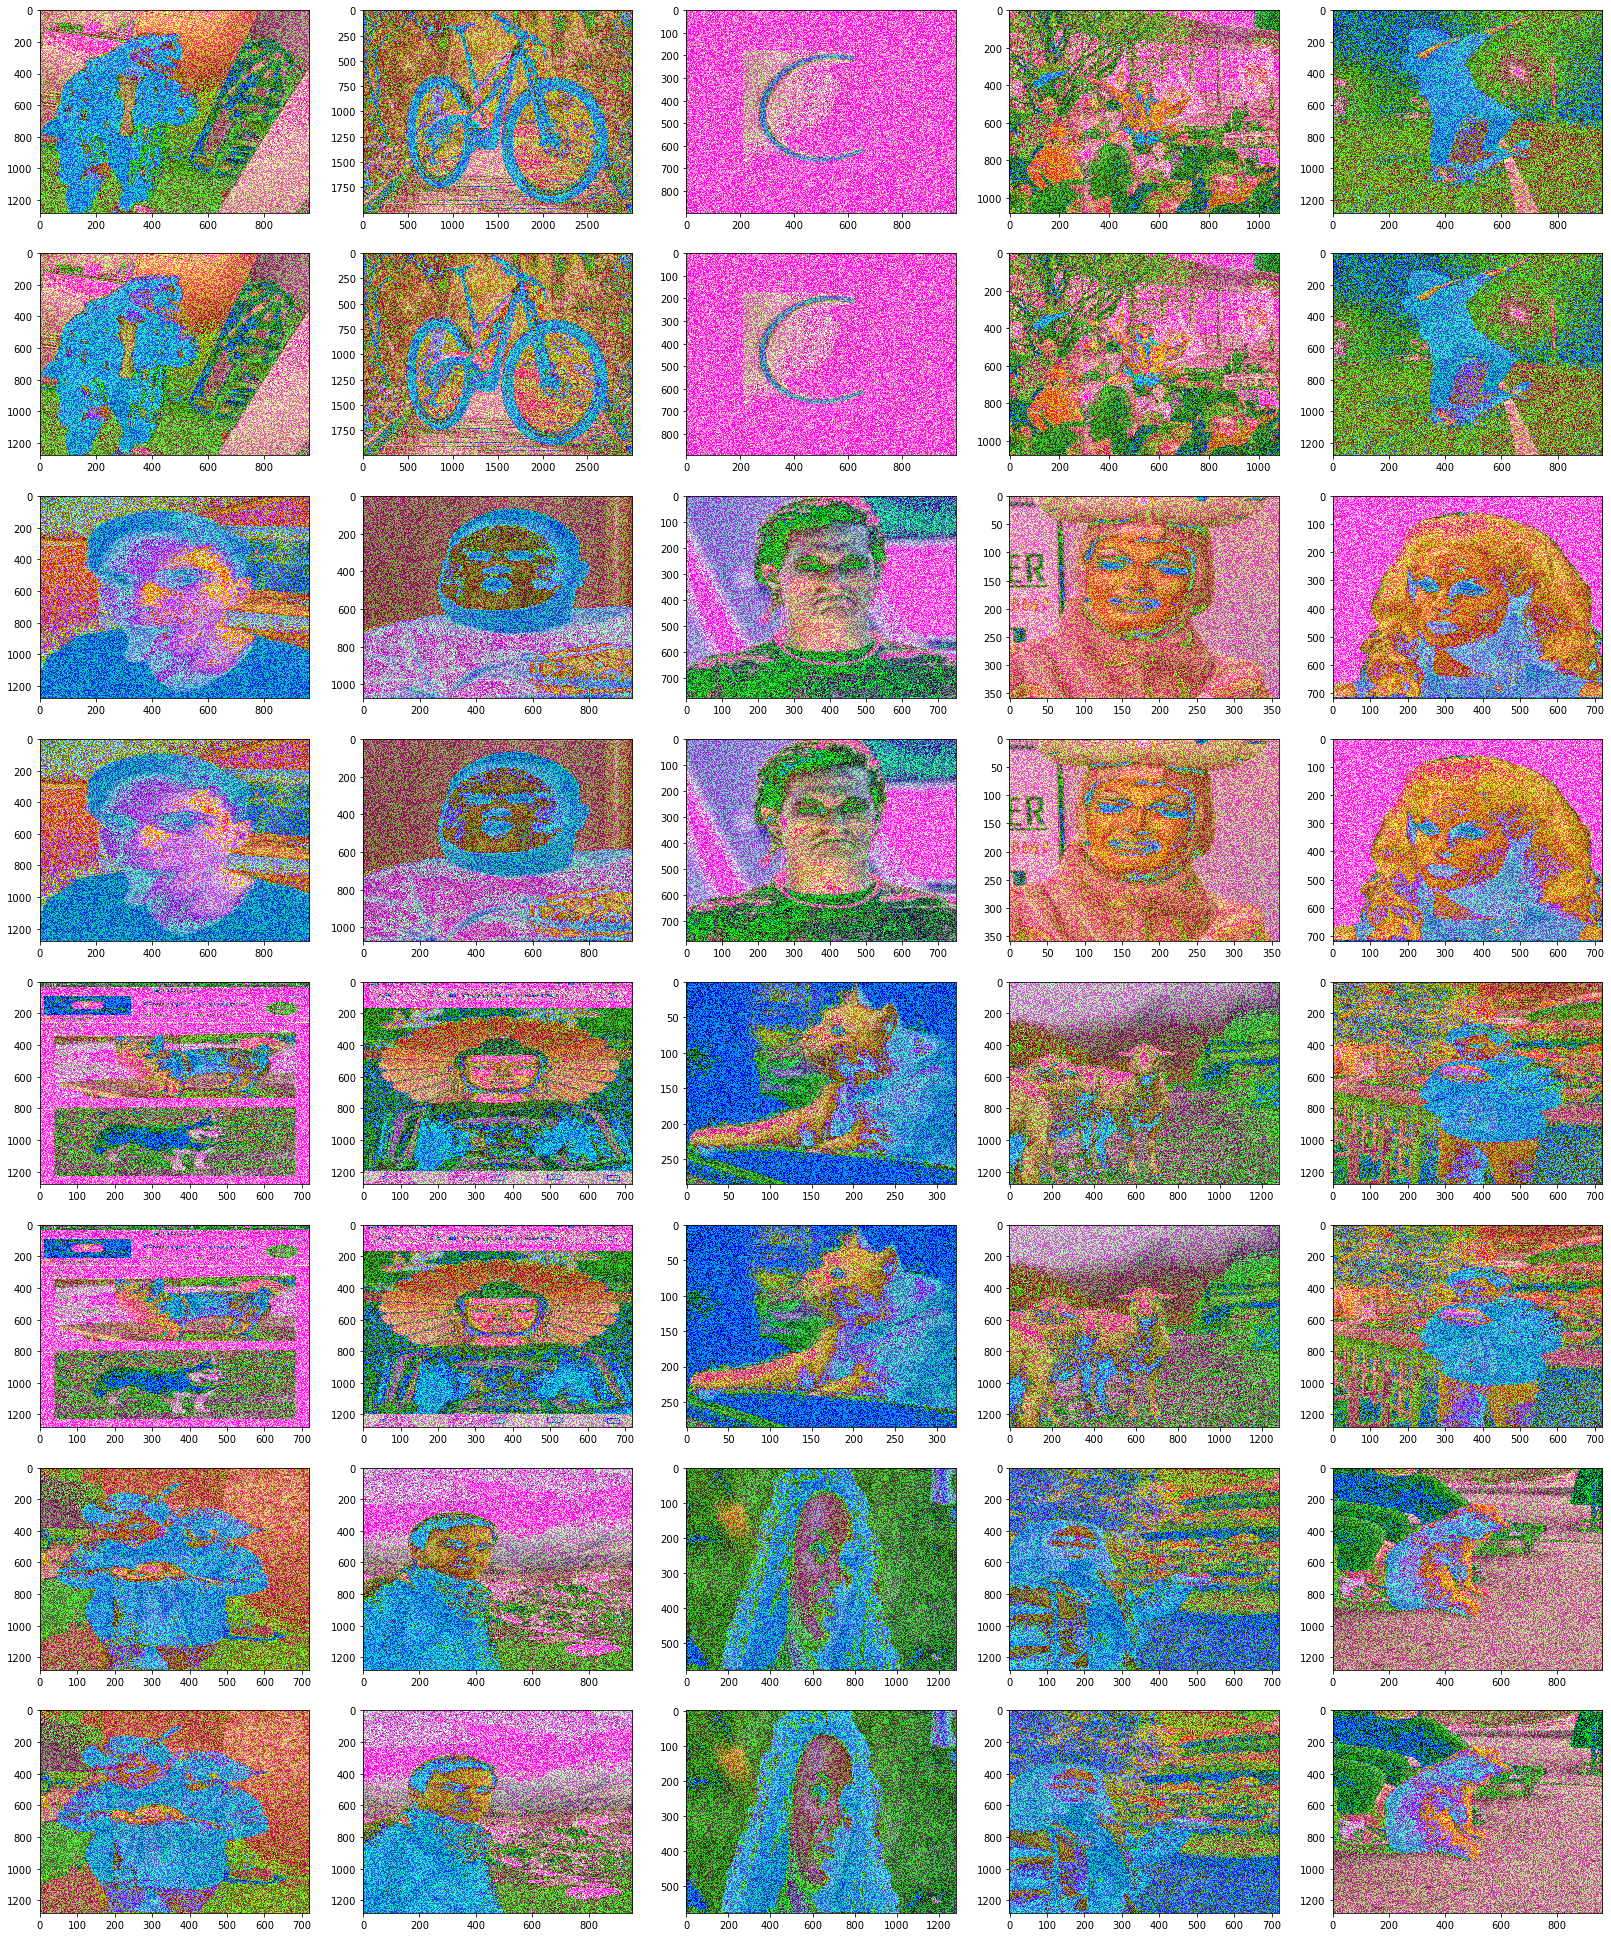

In [28]:
dashboard(modeled_masks)